<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/bayesian_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Uncertainty in Neural Networks

A typical neural network outputs a deterministic value for a given input. In this respect, a neural network is basically a function that computes the output by multiplying weights plus a biase for the input.

$$ H = W \cdot X + b $$

Then a non-linearity is applied through an activation function $ g $ to get the output that we want.

$$ \hat Y = g(H) $$

In reality, the deterministic nature of the neural network creates problems when we want to model uncertainties. For instance, when a neural network trained on MNIST dataset always predicts a single value even if the given input is a totally random image.

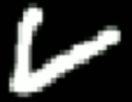

In this case, the correct answer should be 'I don't know' or 'maybe 2 or 4' with low confidence. However, there is no way of knowing how confident the model is about its prediction. The ability for the AI systems to output their prediciton confidence becomes necessary as they take on more life-critical functions. The purpose of the notebook is to survey available methods in modeling uncertainty.

## Types of uncertainties
There are two type of uncertainties.
1. aleatoric uncertainty: the uncertainty comes from the natura of the data itself and thus it is called 'data uncertainty'. The network's performance cannot be improved simply by adding more data.
2. epistemic uncertainty: the network doesn't have the confidence in its prediction. Out of distribution predictions (for instance, trying to predict on a dataset that is quite different from the training dataset) belong to this category of uncertainty.

## Approaches to model uncertainty

There seems to be two approach to model uncertainty. First is to learn the probability distributions through a neural network itself. Second is to assemble an ensemble of competing models to get a sense of how confident we should be about the predictions. Since the probabilistic approach provides the probability and the confidence level, we will focus on this.

## Bayesian Neural Network Intuition

For probability modeling, Bayesian neural network is often used. The intuition behind Bayesian neural network is to learn weight distributions of the model given the prior and the evidence.

$$ P(w|D) = \frac{P(D|w) \cdot P(w)}{P(D)} $$

The data here refers to the input and the expected ground truth label so the equation is sometimes written as:

$$ P(W|X, Y) = \frac{P(Y | X, W) \cdot P(W)}{P(Y | X)} $$




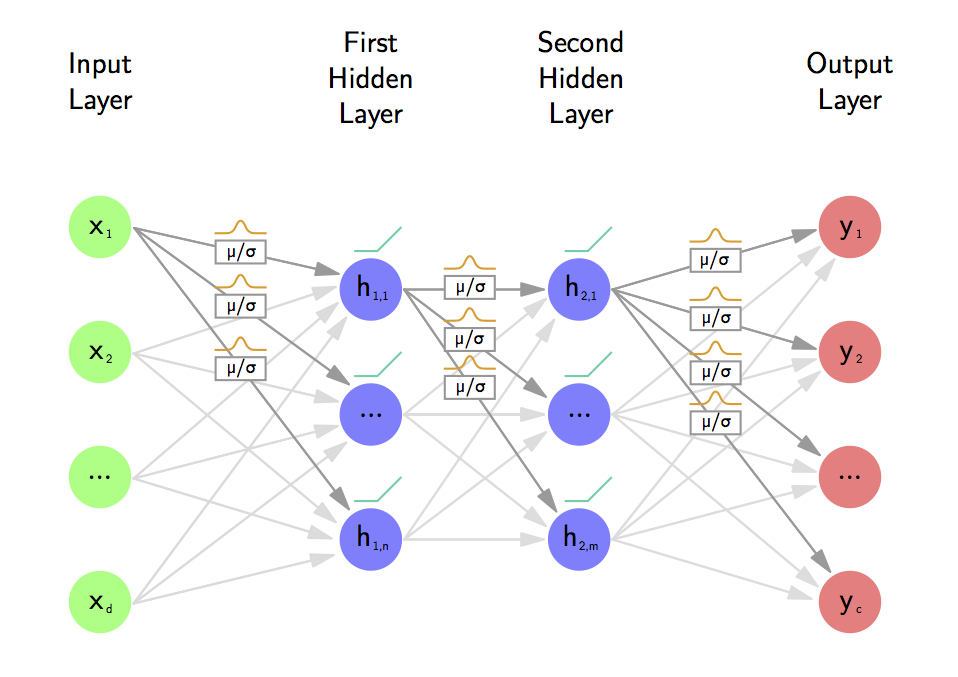

# Implementation

## Import libraries

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt


## Define hyperparameters

In [2]:
NUM_OF_CLASSES = 10
BATCH_SIZE = 128
# BATCH_SIZE = 32
EPOCHS = 10
# input image dimensions
IMG_ROWS, IMG_COLS = 28, 28

## Prepare MNINST data
Load the dataset. [MNIST](https://en.wikipedia.org/wiki/MNIST_database) is a built-in dataset in TensorFlow.

In [61]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0
Y_train = to_categorical(Y_train, NUM_OF_CLASSES)
Y_test = to_categorical(Y_test, NUM_OF_CLASSES)

from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

In [62]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(48000, 28, 28)
(48000, 10)
(12000, 28, 28)
(12000, 10)
(10000, 28, 28)
(10000, 10)


In [63]:
data_format = K.image_data_format()
print(data_format)

channels_last


In [79]:
if data_format == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, IMG_ROWS, IMG_COLS)
    X_val = X_val.reshape(X_val.shape[0], 1, IMG_ROWS, IMG_COLS)
    X_test = X_test.reshape(X_test.shape[0], 1, IMG_ROWS, IMG_COLS)
    input_shape = (1, IMG_ROWS, IMG_COLS)
else:
    X_train = X_train.reshape(X_train.shape[0], IMG_ROWS, IMG_COLS, 1)
    X_val = X_val.reshape(X_val.shape[0], IMG_ROWS, IMG_COLS, 1)
    X_test = x_test.reshape(X_test.shape[0], IMG_ROWS, IMG_COLS, 1)
    input_shape = (IMG_ROWS, IMG_COLS, 1)

In [80]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(48000, 28, 28, 1)
(48000, 10)
(12000, 28, 28, 1)
(12000, 10)
(10000, 28, 28, 1)
(10000, 10)


# Convolutional Neural Network
First, let's build a digit recognition model using CNN.


## Build CNN Model

In [46]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_OF_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [26]:
print('TensorFlow version (expected = 2.0.0):', tf.__version__)
print('TensorFlow Probability version (expected = 0.9.0-dev20190912):', tfp.__version__)

TensorFlow version (expected = 2.0.0): 2.4.1
TensorFlow Probability version (expected = 0.9.0-dev20190912): 0.12.1


Specify the optimizer for backpropagation. Note that the loss (cost) funciton is cross entropy that tends to go hand-in-hand with softmax activation function.

In [9]:
optimizer = keras.optimizers.Adadelta() 
loss = keras.losses.categorical_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Train CNN

Ready for training finally. Let's roll.

In [10]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 19s 6ms/step - loss: 2.2882 - accuracy: 0.1425 - val_loss: 2.2355 - val_accuracy: 0.3302
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 2.2291 - accuracy: 0.2560 - val_loss: 2.1542 - val_accuracy: 0.5176
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 2.1483 - accuracy: 0.3662 - val_loss: 2.0378 - val_accuracy: 0.6188
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 2.0360 - accuracy: 0.4501 - val_loss: 1.8814 - val_accuracy: 0.6719
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 1.8892 - accuracy: 0.5137 - val_loss: 1.6887 - val_accuracy: 0.7027
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 1.7154 - accuracy: 0.5605 - val_loss: 1.4771 - val_accuracy: 0.7332
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 1.5352 - accuracy: 0.5950 - val_loss: 1.2731 - val_accuracy: 0.7620
Epoch

## Evaluate the model

In [11]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.8482 - accuracy: 0.8156


[0.8482228517532349, 0.8155999779701233]

In [12]:
CLASS_NAMES = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(CLASS_NAMES)

preds = model.predict(x_test)

preds_single = CLASS_NAMES[np.argmax(preds, axis = -1)]
actual_single = CLASS_NAMES[np.argmax(y_test, axis = -1)]

[0 1 2 3 4 5 6 7 8 9]


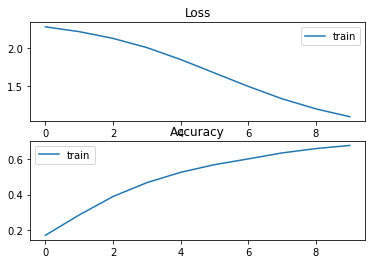

In [13]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()

# plot mse during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show()

## Show Results

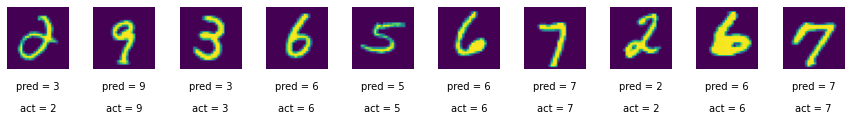

In [19]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(np.squeeze(img))

# Bayesian Neural Network


## Build BNN Model

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

model_bayesian = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    tfp.layers.DenseFlipout(NUM_OF_CLASSES, activation='softmax')
])
model_bayesian.summary()

NameError: ignored

In [ ]:
optimizer = keras.optimizers.Adadelta() 
loss = keras.losses.categorical_crossentropy

model_bayesian.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
history = model_bayesian.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test))

In [ ]:
model_bayesian.evaluate(x_test, y_test)

In [ ]:

preds_bayesian = model_bayesian.predict(x_test)

preds_single_bayesian = CLASS_NAMES[np.argmax(preds_bayesian, axis = -1)]
actual_single = CLASS_NAMES[np.argmax(y_test, axis = -1)]

Predict means inferencing.

Show the training loss and accuracy.

Show the results in UI.

In [ ]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single_bayesian[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(np.squeeze(img))

# Bayesian Neural Network
The BNN implementation is adopted from

https://www.kaggle.com/piesposito/bayesian-nerual-networks-with-tensorflow-2-0


## 4.2 Implementing the Bayesian model with TFP Layers

In [27]:
def build_bayesian_bcnn_model(input_shape):
    
    """
    Here we use tf.keras.Model to use our graph as a Neural Network:
    We select our input node as the net input, and the last node as our output (predict node).
    Note that our model won't be compiled, as we are usign TF2.0 and will optimize it with
    a custom @tf.function for loss and a @tf.function for train_step
    Our input parameter is just the input shape, a tuple, for the input layer
    """
    
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
    x = dense_1(x)
    dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model



    # def build_cnn(input_shape):
    
    # ##model building
    # model = tf.keras.models.Sequential()
    # #convolutional layer with rectified linear unit activation
    # model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
    #                  activation='relu',
    #                  input_shape=input_shape))
    # #32 convolution filters used each of size 3x3
    # #again
    # model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    # #64 convolution filters used each of size 3x3
    # #choose the best features via pooling
    # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # #randomly turn neurons on and off to improve convergence
    # model.add(tf.keras.layers.Dropout(0.25))
    # #flatten since too many dimensions, we only want a classification output
    # model.add(tf.keras.layers.Flatten())
    # #fully connected to get all relevant data
    # model.add(tf.keras.layers.Dense(128, activation='relu'))
    # #one more dropout for convergence' sake :) 
    # model.add(tf.keras.layers.Dropout(0.5))
    # #output a softmax to squash the matrix into output probabilities
    # model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    # return model

## 4.3 Implementing the ELBO Loss function

In [28]:
"""
this is our loss function: a sum of KL Divergence and Softmax crossentropy
We use the @tf.function annotation becuase of TF2.0, and need no placeholders
we get each loss and return its mean
"""

@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

## 4.4 Implementing the train function

In [70]:
"""
this is our train step with tf2.0, very elegant:
We do our flow of the tensors over the model recording its gradientes
Then, our gradient tape to give us a list of the gradients of each parameter in relation of the loss
we dan ask our previously instanced optimizer to apply those gradients to the variable
It is cool to see that it works even with TensorFlow probability- probabilistic layers parameters
"""
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = bcnn(X_train)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bcnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bcnn.trainable_variables))
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))

## 4.5 Wrap-up and train the BNN

We will se that our BNN takes mroe time to start converging

In [68]:
Y_train.shape

(48000, 10)

In [49]:
bcnn = build_bayesian_bcnn_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [66]:
assert(Y_train.shape[0] == X_train.shape[0])

In [71]:
import time
"""
in our train step we can see that it lasts more tha na normal CNN to converge
on the other side, we can have the confidence interval for our predictions, which are 
wonderful in terms of taking sensitive predictions
"""
times = []
accs = []
val_accs = []
losses = []
val_losses = []
for i in range(20):
    tic = time.time()
    loss = train_step(X_train, Y_train)
    preds = bcnn(X_train)
    acc = accuracy(preds, Y_train)
    accs.append(acc)
    losses.append(loss)
    
    val_preds = bcnn(X_val)
    val_loss = elbo_loss(Y_val, val_preds)
    val_acc = accuracy(Y_val, val_preds)
    
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    tac = time.time()
    train_time = tac-tic
    times.append(train_time)
    
    print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, val_loss = {:7.3f}, val_acc={:7.3f} time: {:7.3f}".format(i, loss, acc, val_loss, val_acc, train_time))

Epoch: 0: loss =  25.902 , accuracy =   0.152, val_loss =   6.540, val_acc=  0.159 time:  10.396
Epoch: 1: loss =   6.433 , accuracy =   0.154, val_loss =   7.918, val_acc=  0.159 time:   0.595
Epoch: 2: loss =   7.880 , accuracy =   0.155, val_loss =   7.189, val_acc=  0.153 time:   0.584
Epoch: 3: loss =   7.009 , accuracy =   0.148, val_loss =   5.997, val_acc=  0.152 time:   0.587
Epoch: 4: loss =   6.031 , accuracy =   0.184, val_loss =   3.831, val_acc=  0.189 time:   0.586
Epoch: 5: loss =   3.837 , accuracy =   0.214, val_loss =   2.781, val_acc=  0.210 time:   0.590
Epoch: 6: loss =   2.732 , accuracy =   0.233, val_loss =   2.324, val_acc=  0.226 time:   0.600
Epoch: 7: loss =   2.328 , accuracy =   0.216, val_loss =   2.115, val_acc=  0.237 time:   0.586
Epoch: 8: loss =   2.089 , accuracy =   0.295, val_loss =   1.921, val_acc=  0.284 time:   0.587
Epoch: 9: loss =   1.913 , accuracy =   0.414, val_loss =   1.729, val_acc=  0.400 time:   0.590
Epoch: 10: loss =   1.698 , ac

### Accuracy and loss evolution:

Some metrics to illustrate its evolution. We can see from the logs above that our BNN is generalizing very well on the validation set. On the other side, it lasts much more to train.

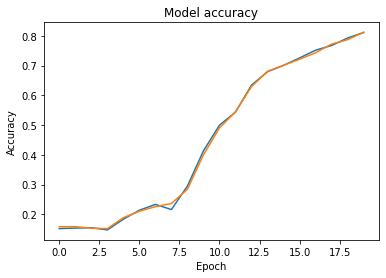

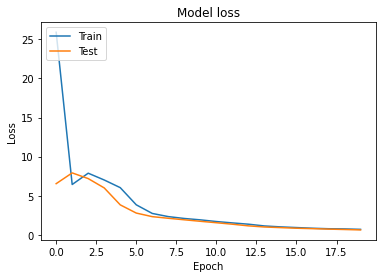

In [72]:
#plotting accuracy
plt.plot(np.array(accs), label="acc")
plt.plot(np.array(val_accs), label="val_acc")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation loss values
plt.plot(np.array(losses), label="loss")
plt.plot(np.array(val_losses), label="val_loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 5. Predicting with Monte Carlo methods and epistemic uncertainity gathering

## 5.1 Notes on the prediction method

We will now use our trained Bayesian Neural Network to predict on labeled real values and noisy ones. Our approach will consist in sampling 30 predictions for each value, then see the prediction distribution. The neural network will be set to "I don't know" if it cant predict, with confidence, any value. To predict a value, using the montecarlo method, the median of the labels predicted probability must surpass 0.35.

We want to show that, the more the sampled networks predict on the mode prediction, the more reliable the prediction will be. On the other side, "confuse" and uncertain predictions will have the predictions distributed on more labels, approximating to a uniform distribution.

In order to to that, we are implementing functions to gather and plot those distributions.
    

### Plot prediction histogram function:

The function below plots the histograms for each label probabilities prediction and will be used to visualize our data. This function was mostly from Zhullingchen GitHub (with minor changes).

Here is the link of the repo, which I strongly recomend you give a look: [TFP tutorial from Zhulingchen](https://github.com/zhulingchen/tfp-tutorial/)

In [73]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median probability: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

## 5.2 Gathering the prediction distribution

On the snippet below, we just apply the Monte Carlo technique to sample and predict labels 30 times for each image on the validation set. We then store those predictions on lists to plot the distribution and gather insights.

In [74]:
n_mc_run = 50
med_prob_thres = 0.35

y_pred_logits_list = [bcnn(X_val) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([tf.nn.softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(Y_val[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(Y_val[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(Y_val[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(Y_val[idx_invalid]))

Number of recognizable samples: 11679
Unrecognizable samples: [    9    20    58    83   106   121   184   209   223   227   237   279
   294   297   323   334   379   394   400   427   474   489   530   538
   560   562   603   721   727   854   858   909   917   918   921   935
   940   988  1051  1074  1086  1221  1240  1298  1301  1304  1401  1410
  1483  1515  1531  1563  1583  1610  1627  1659  1795  1823  1840  1847
  1857  1879  2154  2161  2308  2421  2445  2463  2480  2510  2546  2573
  2591  2616  2671  2708  2724  2730  2747  2756  2772  2808  2814  2839
  2842  2868  2910  2915  2973  2976  3157  3212  3288  3296  3306  3310
  3359  3374  3405  3414  3427  3563  3577  3722  3724  3756  3831  3836
  3914  3922  3945  3962  3965  3982  4054  4087  4126  4176  4207  4248
  4297  4404  4443  4450  4452  4494  4503  4506  4550  4564  4565  4582
  4647  4698  4700  4707  4766  4795  4798  4849  4896  5006  5377  5455
  5473  5501  5630  5642  5670  5684  5687  5698  5771  5801  

## 5.3 Visualizing valid predictions
    

Here we just visualize some well predicted values.

In [76]:
X_val.shape

(12000, 28, 28)

True label of the test sample 0: 3


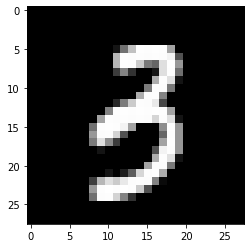

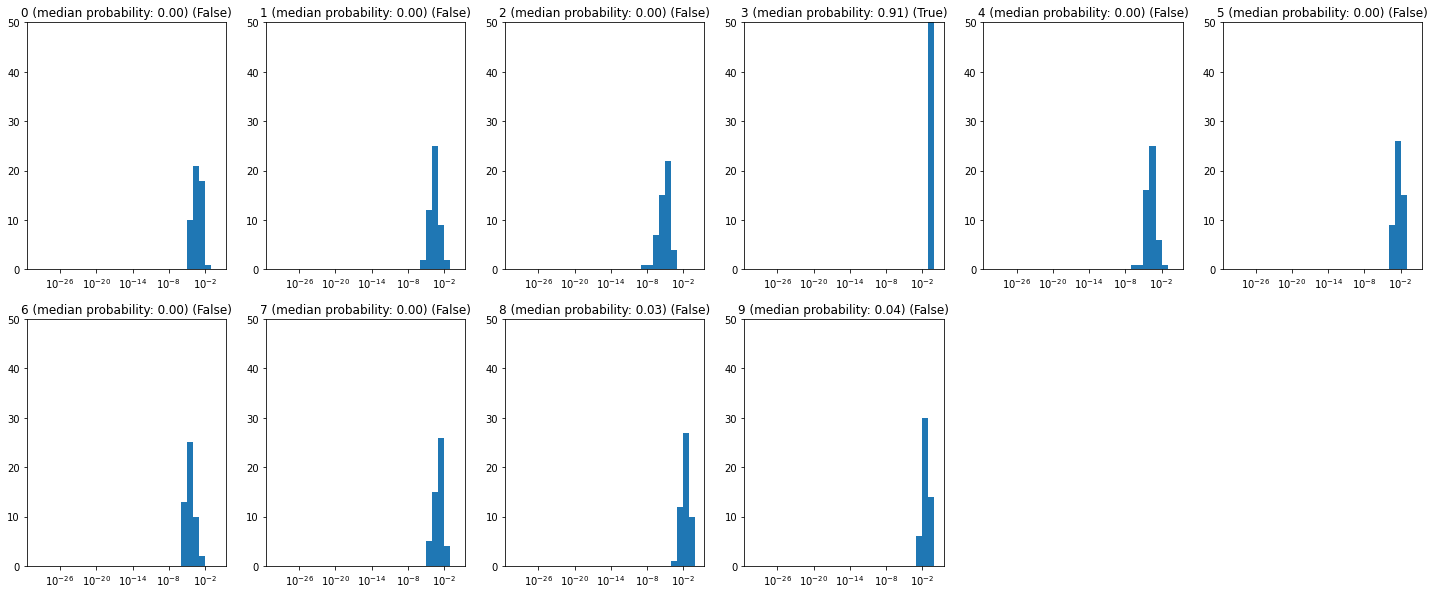

In [81]:
class_nmr = 10
plt.imshow(X_val[0, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(0, np.argmax(Y_val[0], axis=-1)))

plot_pred_hist(y_pred_prob_all[0], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

## 5.4 Visualizing non-predicted values
    

On this snippet we do visualize the noisy images which the network is not able to predict on properly.

True label of the test sample 9: 9


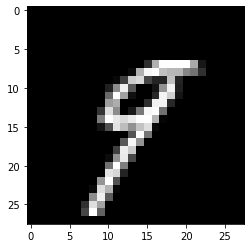

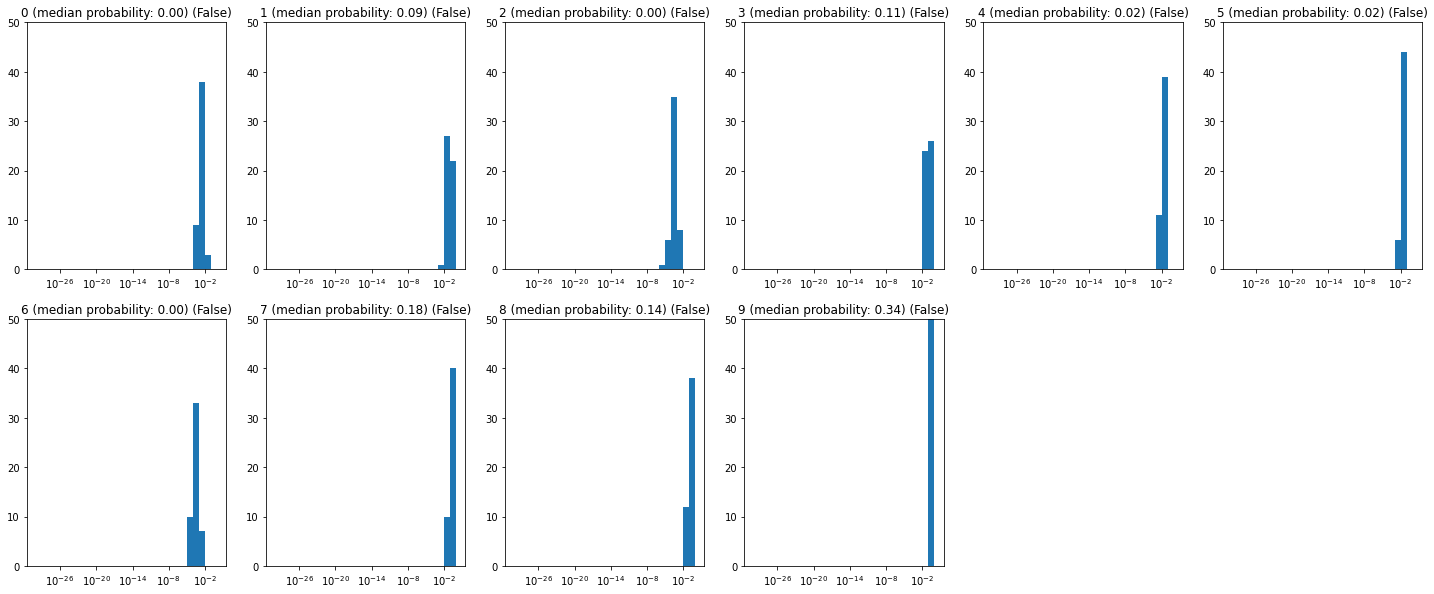

I don't know!
True label of the test sample 20: 3


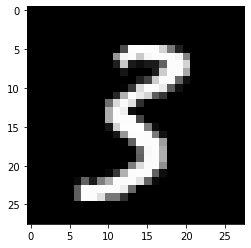

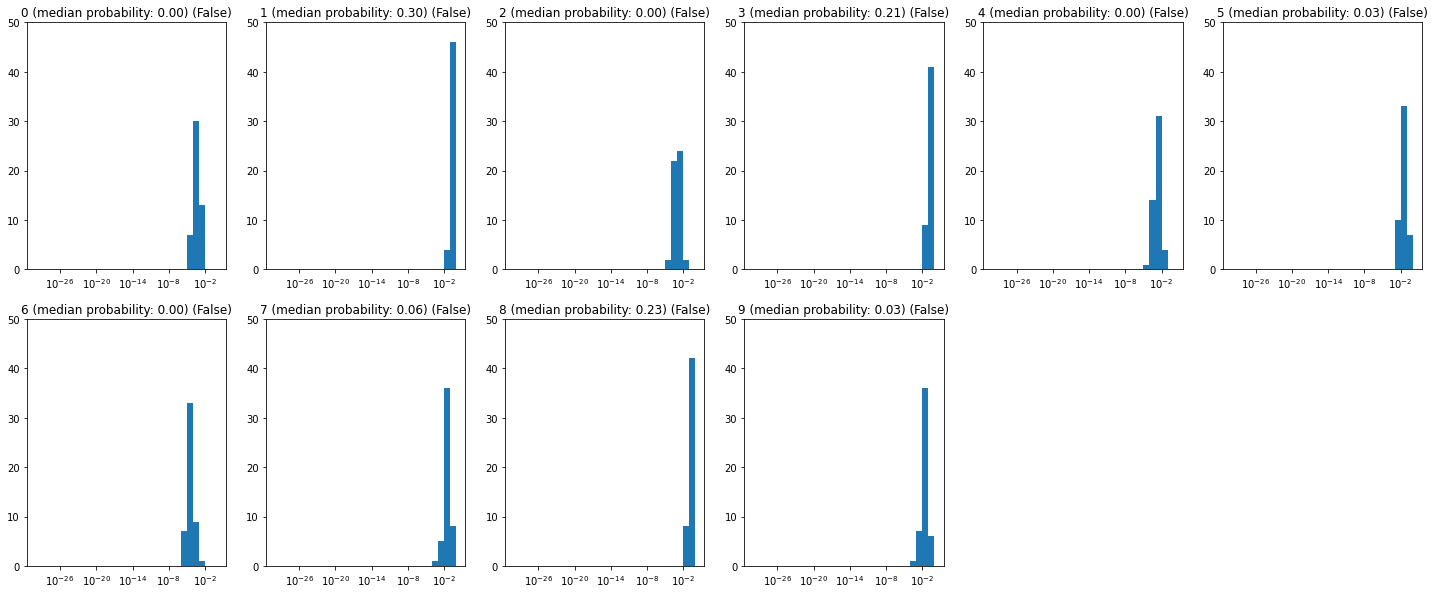

I don't know!
True label of the test sample 58: 5


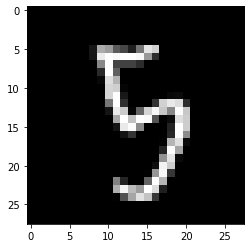

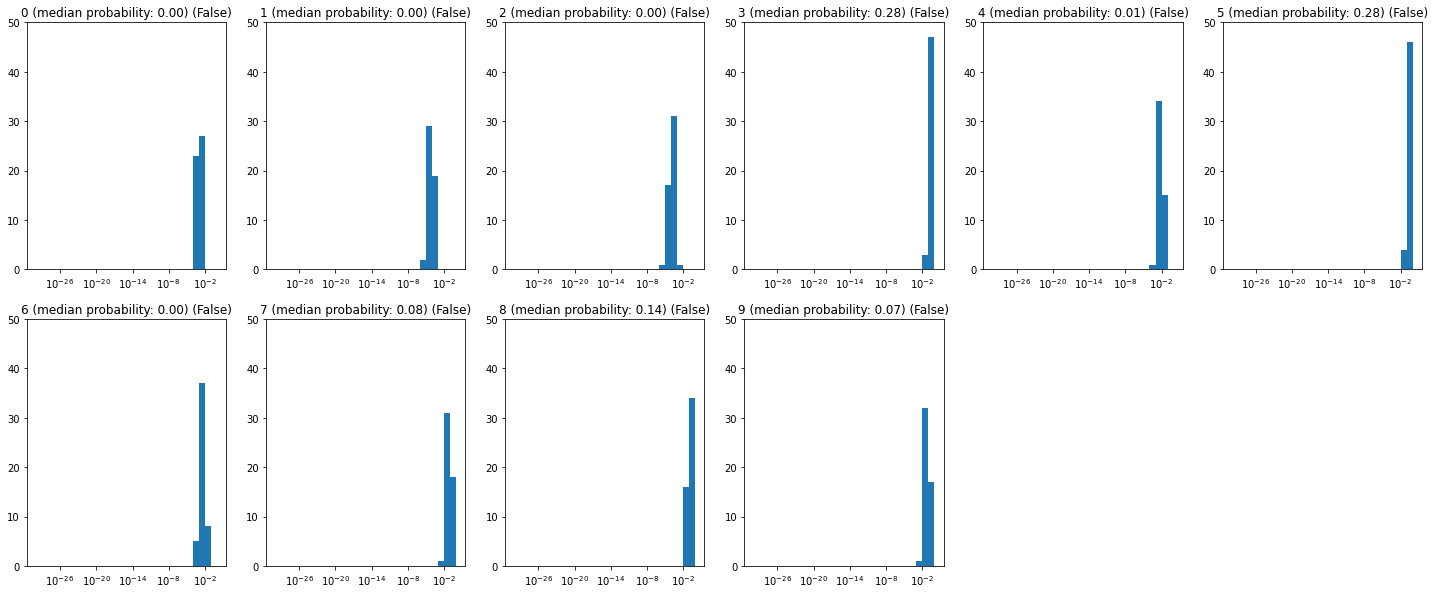

I don't know!
True label of the test sample 83: 7


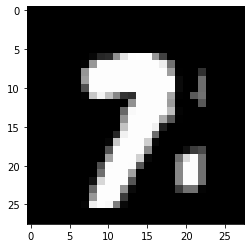

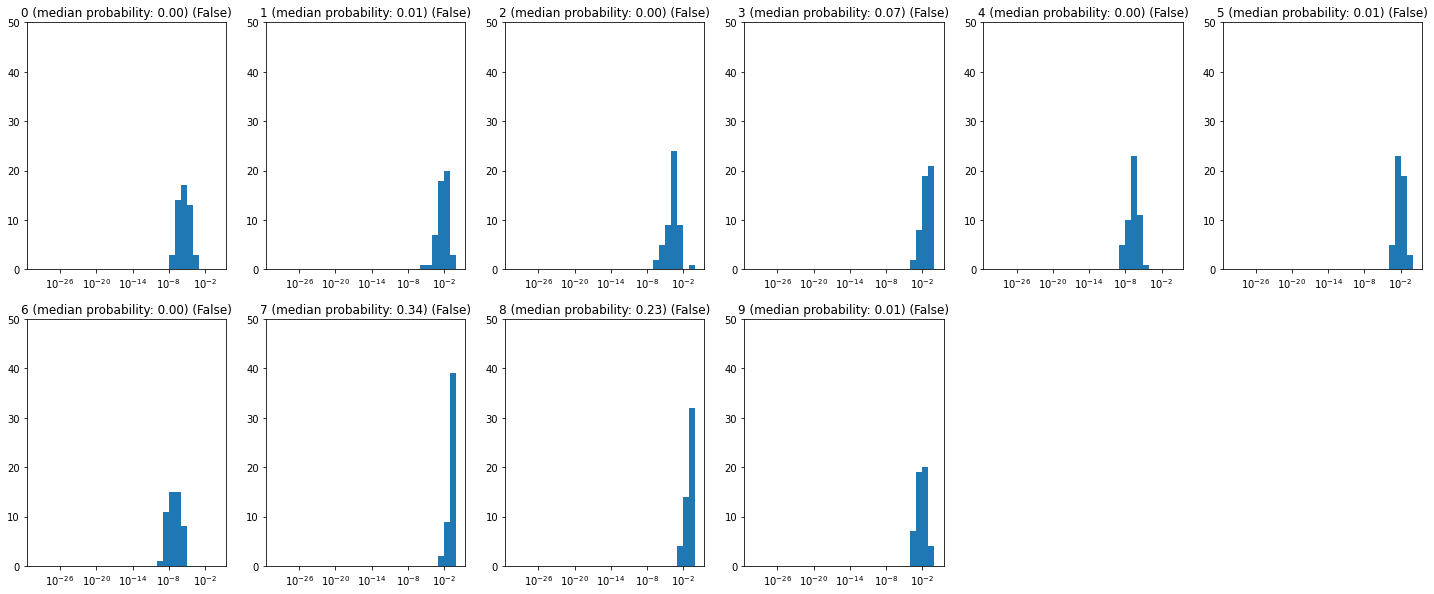

I don't know!
True label of the test sample 106: 3


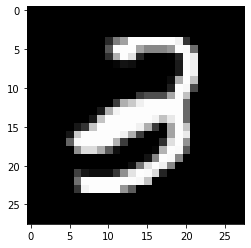

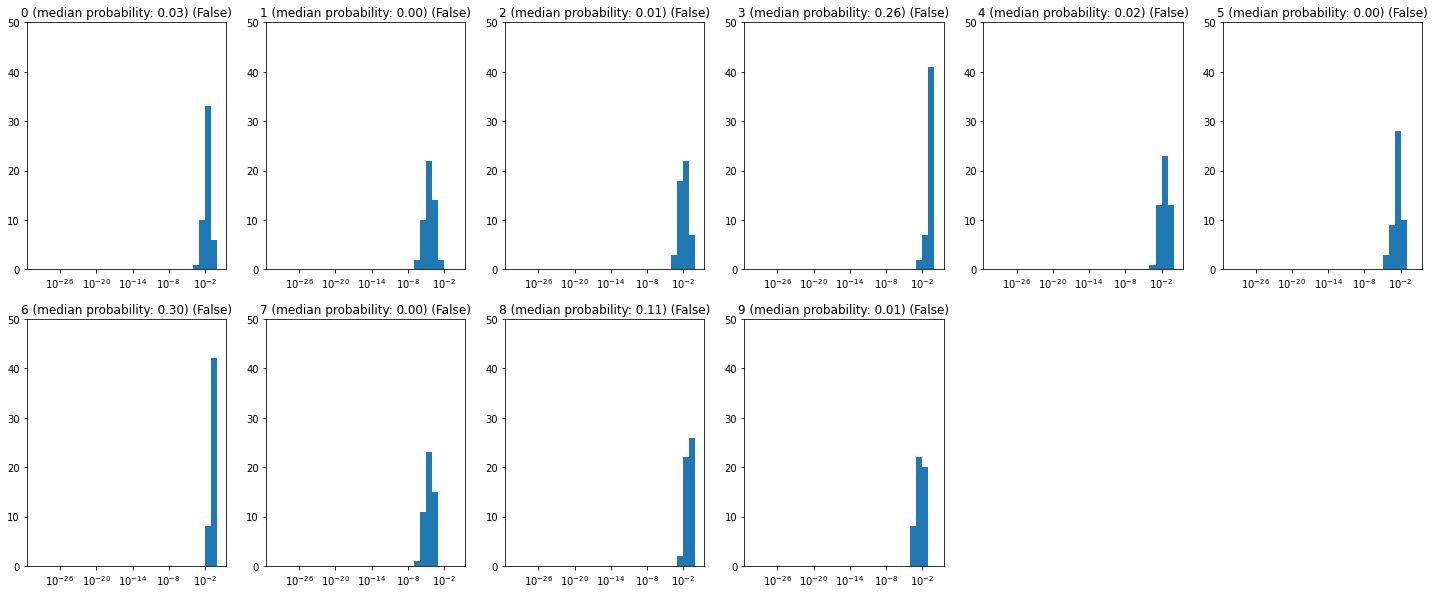

I don't know!
True label of the test sample 121: 3


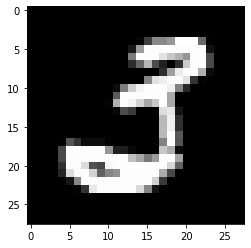

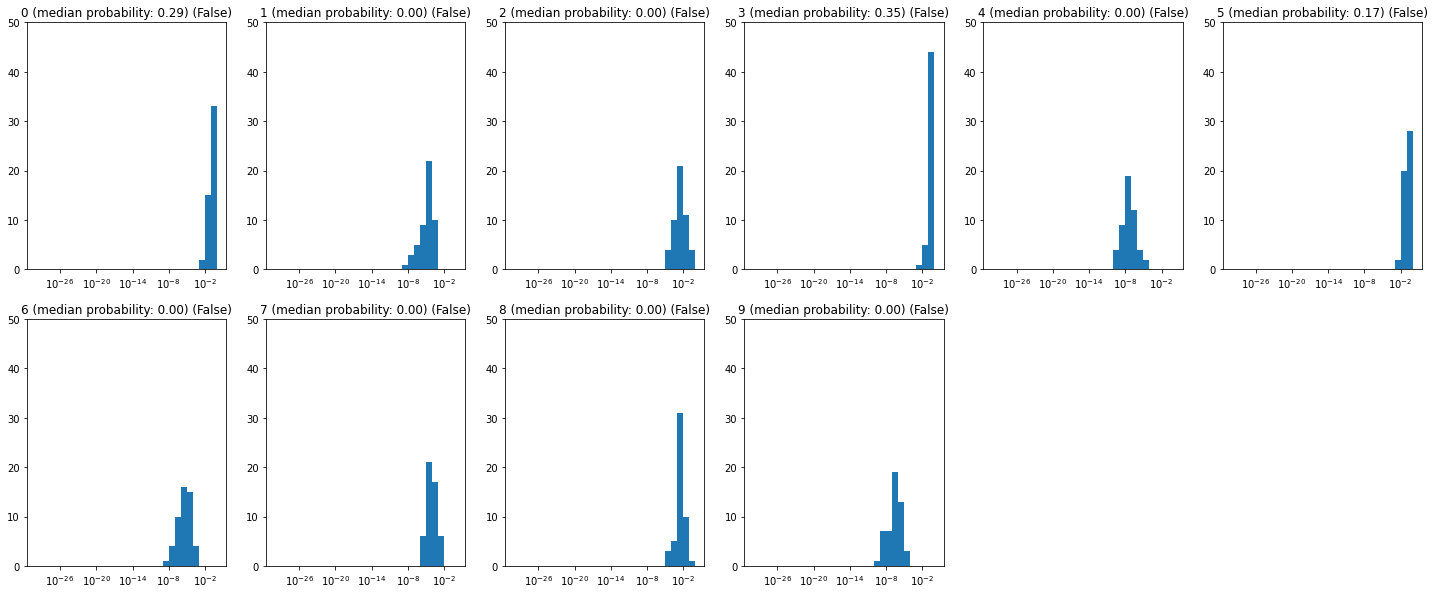

I don't know!


In [82]:
class_nmr = 10
invalids = 0
for idx in np.where(idx_invalid)[0]:
    plt.imshow(X_val[idx, :, :, 0], cmap='gist_gray')
    print("True label of the test sample {}: {}".format(idx, np.argmax(Y_val[idx], axis=-1)))

    plot_pred_hist(y_pred_prob_all[idx], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

    if any(y_pred[idx]):
        print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
    else:
        print("I don't know!")
    invalids += 1
    if invalids > 5:
        break

In [ ]:
end = time.time()
runtime = (end - start) / 60
print("This notebook ran in {:7.3f} minutes".format(runtime))